All datasets loaded successfully.
Datasets merged successfully.
Shape of the final dataframe: (119143, 40)

Starting data cleaning and preprocessing...


/tmp/ipython-input-180903101.py:80: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['product_category_name_english'].fillna('unknown', inplace=True)
/tmp/ipython-input-180903101.py:87: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inp

Data cleaning and feature engineering complete.
Working with 115723 delivered orders.

Performing Exploratory Data Analysis...


/tmp/ipython-input-180903101.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis', orient='h')


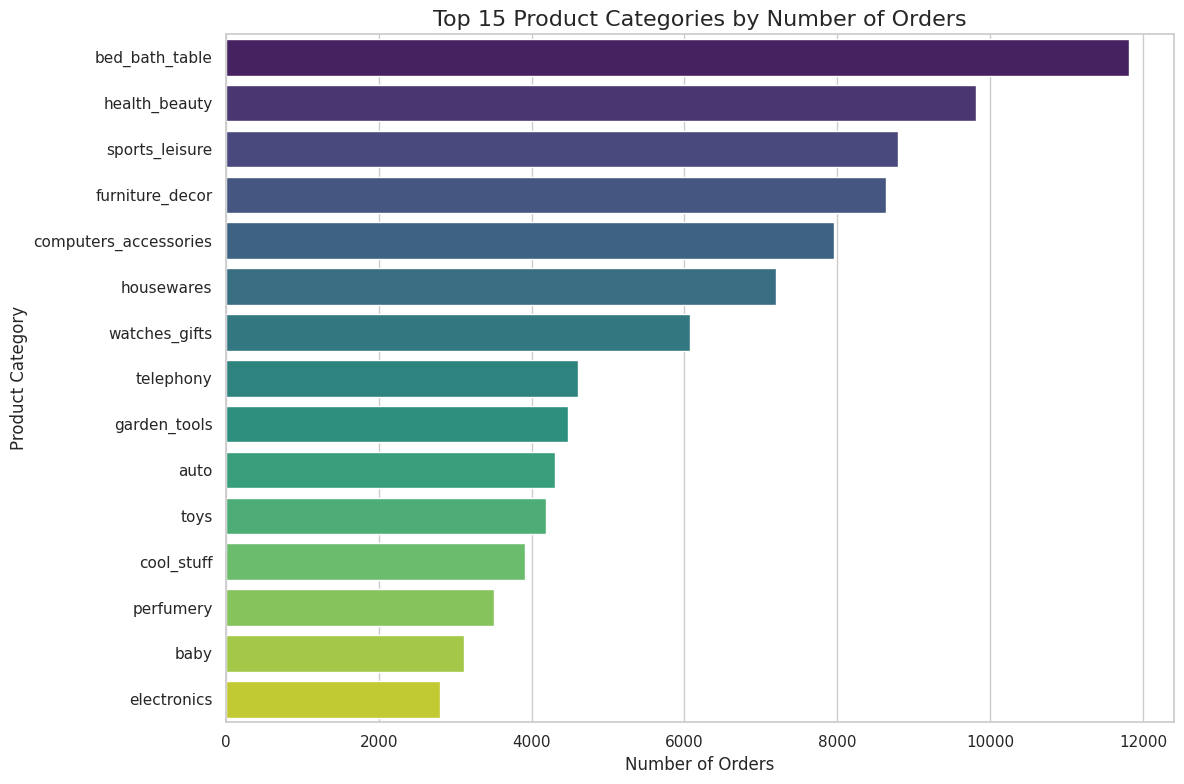

/tmp/ipython-input-180903101.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_states.values, y=top_states.index, palette='plasma')


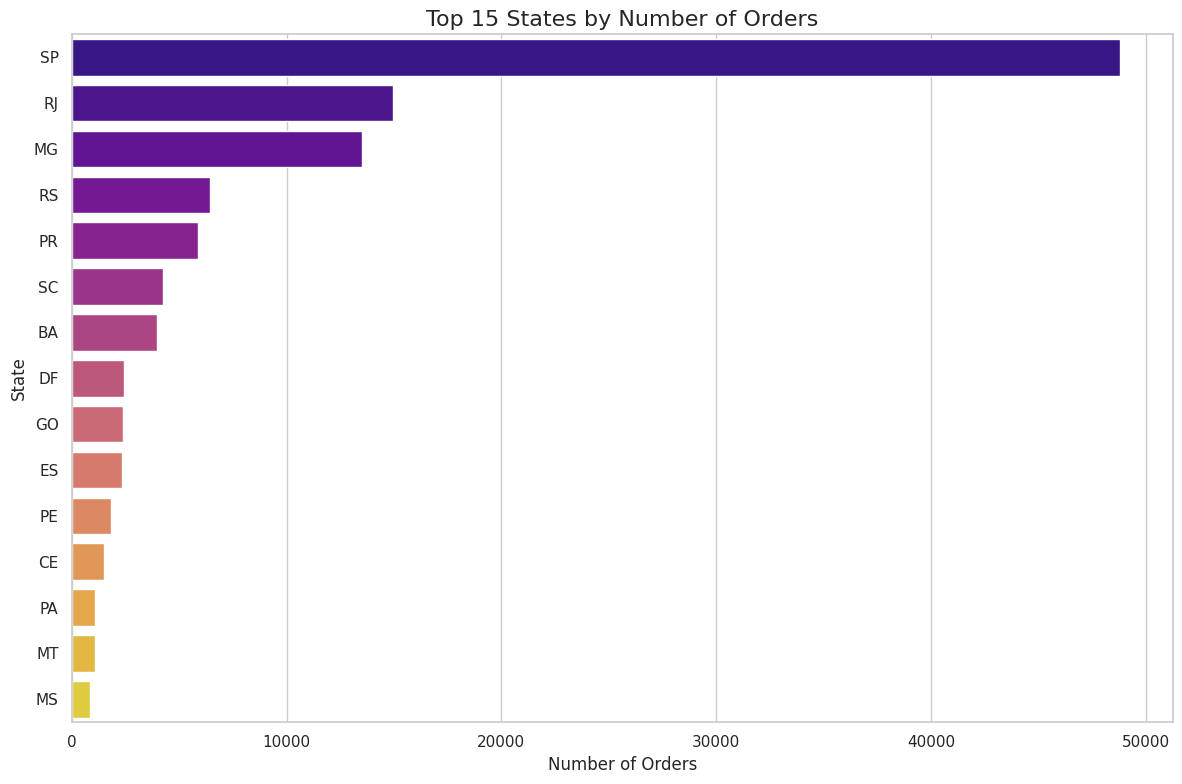


Average Delivery Time: 12.02 days
Late Shipment Rate: 7.84%


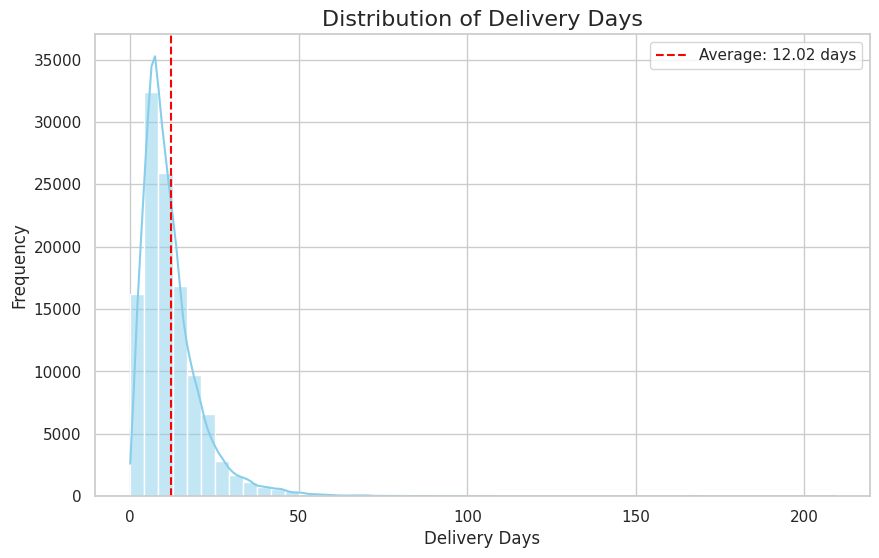

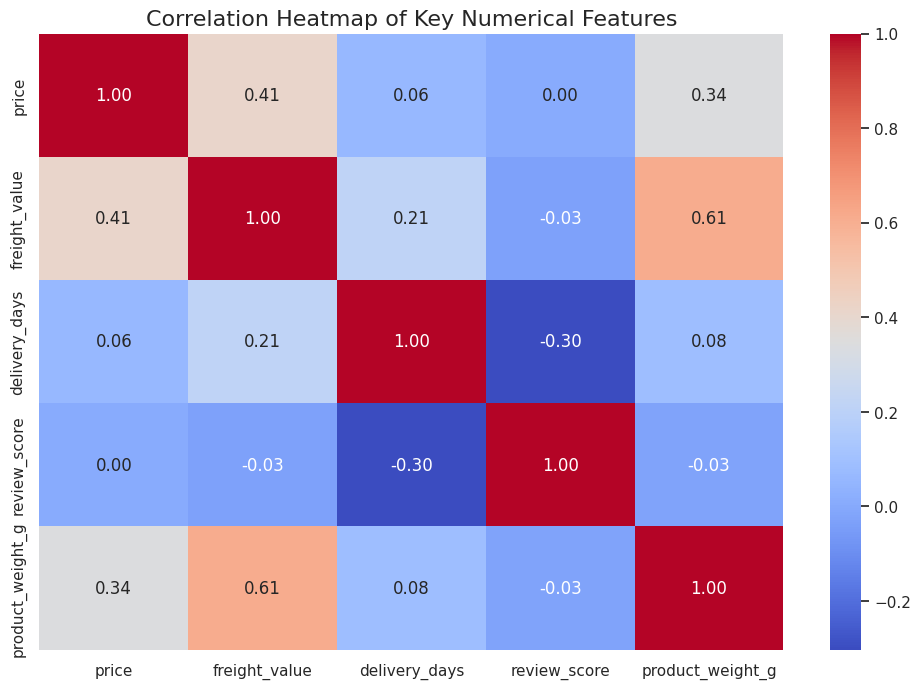


Conducting Pareto (80/20) Analysis...
41.82% of customers account for 80% of the revenue.


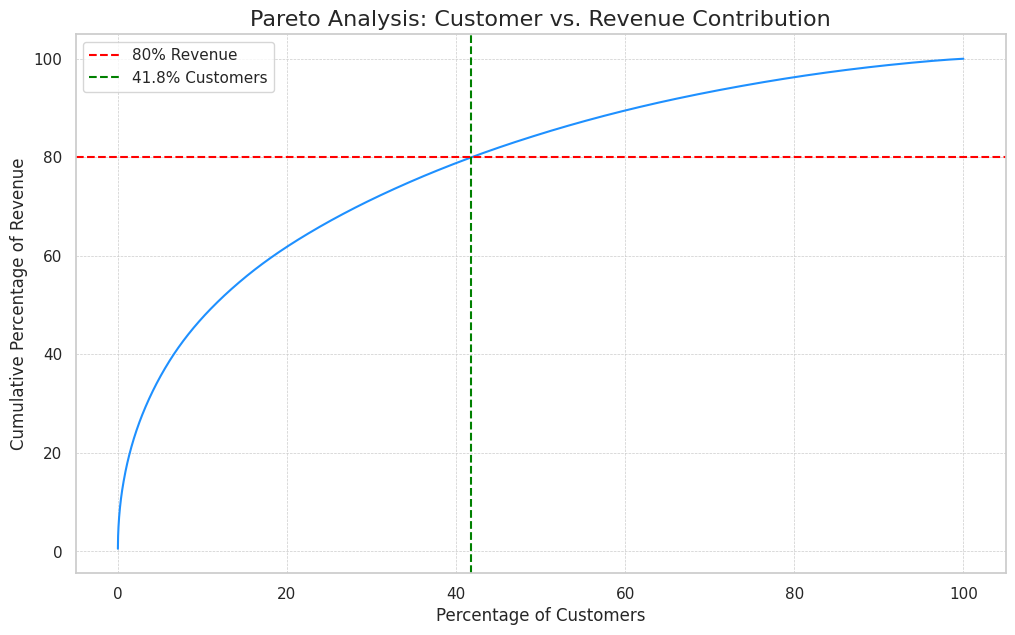


Analysis complete.


In [5]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style for visualizations
sns.set(style='whitegrid')
plt.style.use('seaborn-v0_8-deep')

# Load all the individual CSV files from the Kaggle dataset
try:
    customers = pd.read_csv("olist_customers_dataset.csv")
    geolocation = pd.read_csv("olist_geolocation_dataset.csv")
    order_items = pd.read_csv("olist_order_items_dataset.csv")
    payments = pd.read_csv("olist_order_payments_dataset.csv")
    reviews = pd.read_csv("olist_order_reviews_dataset.csv")
    orders = pd.read_csv("olist_orders_dataset.csv")
    products = pd.read_csv("olist_products_dataset.csv")
    sellers = pd.read_csv("olist_sellers_dataset.csv")
    translation = pd.read_csv("product_category_name_translation.csv")
    print("All datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading data: {e}. Make sure all CSV files are in the correct directory.")
    # Exit or handle the error appropriately
    exit()



# Merge Datasets into a Single DataFrame
# Merge orders with customers
df = pd.merge(orders, customers, on='customer_id', how='left')
# Merge order_items to get product and seller details
df = pd.merge(df, order_items, on='order_id', how='left')
# Merge payments data
df = pd.merge(df, payments, on='order_id', how='left')
# Merge reviews data
df = pd.merge(df, reviews, on='order_id', how='left')
# Merge product data
df = pd.merge(df, products, on='product_id', how='left')
# Merge seller data
df = pd.merge(df, sellers, on='seller_id', how='left')
# Merge category name translations
df = pd.merge(df, translation, on='product_category_name', how='left')

print("Datasets merged successfully.")
print("Shape of the final dataframe:", df.shape)


4. Data Cleaning & Preprocessing
print("\nStarting data cleaning and preprocessing...")

# Convert date columns to datetime objects
date_columns = [
    'order_purchase_timestamp', 'order_approved_at',
    'order_delivered_carrier_date', 'order_delivered_customer_date',
    'order_estimated_delivery_date', 'shipping_limit_date',
    'review_creation_date', 'review_answer_timestamp'
]
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Handle missing values
# For product-related columns, fill with 'unknown' or median
df['product_category_name_english'].fillna('unknown', inplace=True)
# For numerical columns, filling with the median is a robust strategy
numerical_cols_to_fill = [
    'product_name_lenght', 'product_description_lenght', 'product_photos_qty',
    'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm'
]
for col in numerical_cols_to_fill:
    df[col].fillna(df[col].median(), inplace=True)

# Feature Engineering: Create new columns for analysis
# Calculate delivery time in days
df['delivery_days'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

# Flag for late deliveries
df['is_late'] = (df['order_delivered_customer_date'] > df['order_estimated_delivery_date']).astype(int)

# Extract year and month for time-series analysis
df['purchase_year'] = df['order_purchase_timestamp'].dt.year
df['purchase_month'] = df['order_purchase_timestamp'].dt.month

# Filter out orders that were not delivered for accurate analysis
df_delivered = df[df['order_status'] == 'delivered'].copy()

print("Data cleaning and feature engineering complete.")
print(f"Working with {df_delivered.shape[0]} delivered orders.")


# Exploratory Data Analysis (EDA) & Visualizations
print("\nPerforming Exploratory Data Analysis...")

# Sales by Product Category ----
plt.figure(figsize=(12, 8))
top_categories = df_delivered['product_category_name_english'].value_counts().nlargest(15)
sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis', orient='h')
plt.title('Top 15 Product Categories by Number of Orders', fontsize=16)
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Product Category', fontsize=12)
plt.tight_layout()
plt.show()

# Sales by Region (State)
plt.figure(figsize=(12, 8))
top_states = df_delivered['customer_state'].value_counts().nlargest(15)
sns.barplot(x=top_states.values, y=top_states.index, palette='plasma')
plt.title('Top 15 States by Number of Orders', fontsize=16)
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('State', fontsize=12)
plt.tight_layout()
plt.show()

# Delivery Performance Evaluation
avg_delivery_days = df_delivered['delivery_days'].mean()
late_shipment_rate = df_delivered['is_late'].mean() * 100

print(f"\nAverage Delivery Time: {avg_delivery_days:.2f} days")
print(f"Late Shipment Rate: {late_shipment_rate:.2f}%")

plt.figure(figsize=(10, 6))
sns.histplot(df_delivered['delivery_days'].dropna(), bins=50, kde=True, color='skyblue')
plt.title('Distribution of Delivery Days', fontsize=16)
plt.xlabel('Delivery Days', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(avg_delivery_days, color='red', linestyle='--', label=f'Average: {avg_delivery_days:.2f} days')
plt.legend()
plt.show()

# Heatmap of Numerical Features
plt.figure(figsize=(12, 8))
corr_cols = ['price', 'freight_value', 'delivery_days', 'review_score', 'product_weight_g']
correlation_matrix = df_delivered[corr_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Key Numerical Features', fontsize=16)
plt.show()


#Pareto (80/20) Analysis of High-Value Customers
print("\nConducting Pareto (80/20) Analysis...")

# Calculate total revenue per customer
customer_revenue = df_delivered.groupby('customer_unique_id')['payment_value'].sum().sort_values(ascending=False)
customer_revenue_df = customer_revenue.reset_index()
customer_revenue_df.columns = ['customer_unique_id', 'total_revenue']

# Calculate cumulative revenue
customer_revenue_df['cumulative_revenue'] = customer_revenue_df['total_revenue'].cumsum()
customer_revenue_df['cumulative_revenue_percentage'] = (customer_revenue_df['cumulative_revenue'] / customer_revenue_df['total_revenue'].sum()) * 100

# Calculate customer percentage
total_customers = len(customer_revenue_df)
customer_revenue_df['customer_percentage'] = (np.arange(1, total_customers + 1) / total_customers) * 100

# Find the 80/20 crossover point
pareto_point = customer_revenue_df[customer_revenue_df['cumulative_revenue_percentage'] >= 80].iloc[0]
print(f"{pareto_point['customer_percentage']:.2f}% of customers account for 80% of the revenue.")

# Plot Pareto Chart
plt.figure(figsize=(12, 7))
plt.plot(customer_revenue_df['customer_percentage'], customer_revenue_df['cumulative_revenue_percentage'], marker='', color='dodgerblue')
plt.title('Pareto Analysis: Customer vs. Revenue Contribution', fontsize=16)
plt.xlabel('Percentage of Customers', fontsize=12)
plt.ylabel('Cumulative Percentage of Revenue', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add 80/20 lines
plt.axhline(y=80, color='red', linestyle='--', label='80% Revenue')
plt.axvline(x=pareto_point['customer_percentage'], color='green', linestyle='--', label=f"{pareto_point['customer_percentage']:.1f}% Customers")

plt.legend()
plt.show()

print("\nAnalysis complete.")